# Multiple Domain Testing

## Mash Tests

In [2]:
import test_manifold_algorithms as tma
from MASH_MD import MASH
import matplotlib.pyplot as plt
import numpy as np

2024-09-16 09:39:16.245282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 09:39:16.246019: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 09:39:16.249861: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 09:39:16.299838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 09:39:18.059151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### Toy Data

In [3]:
d1 = np.random.randint(10, size = (3, 4))
d2 = np.random.randint(10, size = (3, 2))
d3 = np.random.randint(10, size = (3, 4))
d3

array([[1, 7, 5, 0],
       [4, 5, 1, 4],
       [1, 7, 0, 4]])

Time Data Below
 Time it took to execute the graph for domain 0:  0.03801
 Time it took to compute kernal 0:  4e-05
 Time it took to execute SGDM for domain 1:  0.00039
 Time it took to execute the graph for domain 1:  0.02657
 Time it took to execute the graph for domain 2:  0.12094
 Time it took to compute kernal 2:  2e-05
Length of weights to add: 3
Length of edges to add: 0
Length of edges to add: 0
Length of edges to add: 1
Length of edges to add: 2
Length of weights to add: 4
Length of edges to add: 2
Length of edges to add: 2
Length of edges to add: 0
Length of edges to add: 0


/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(


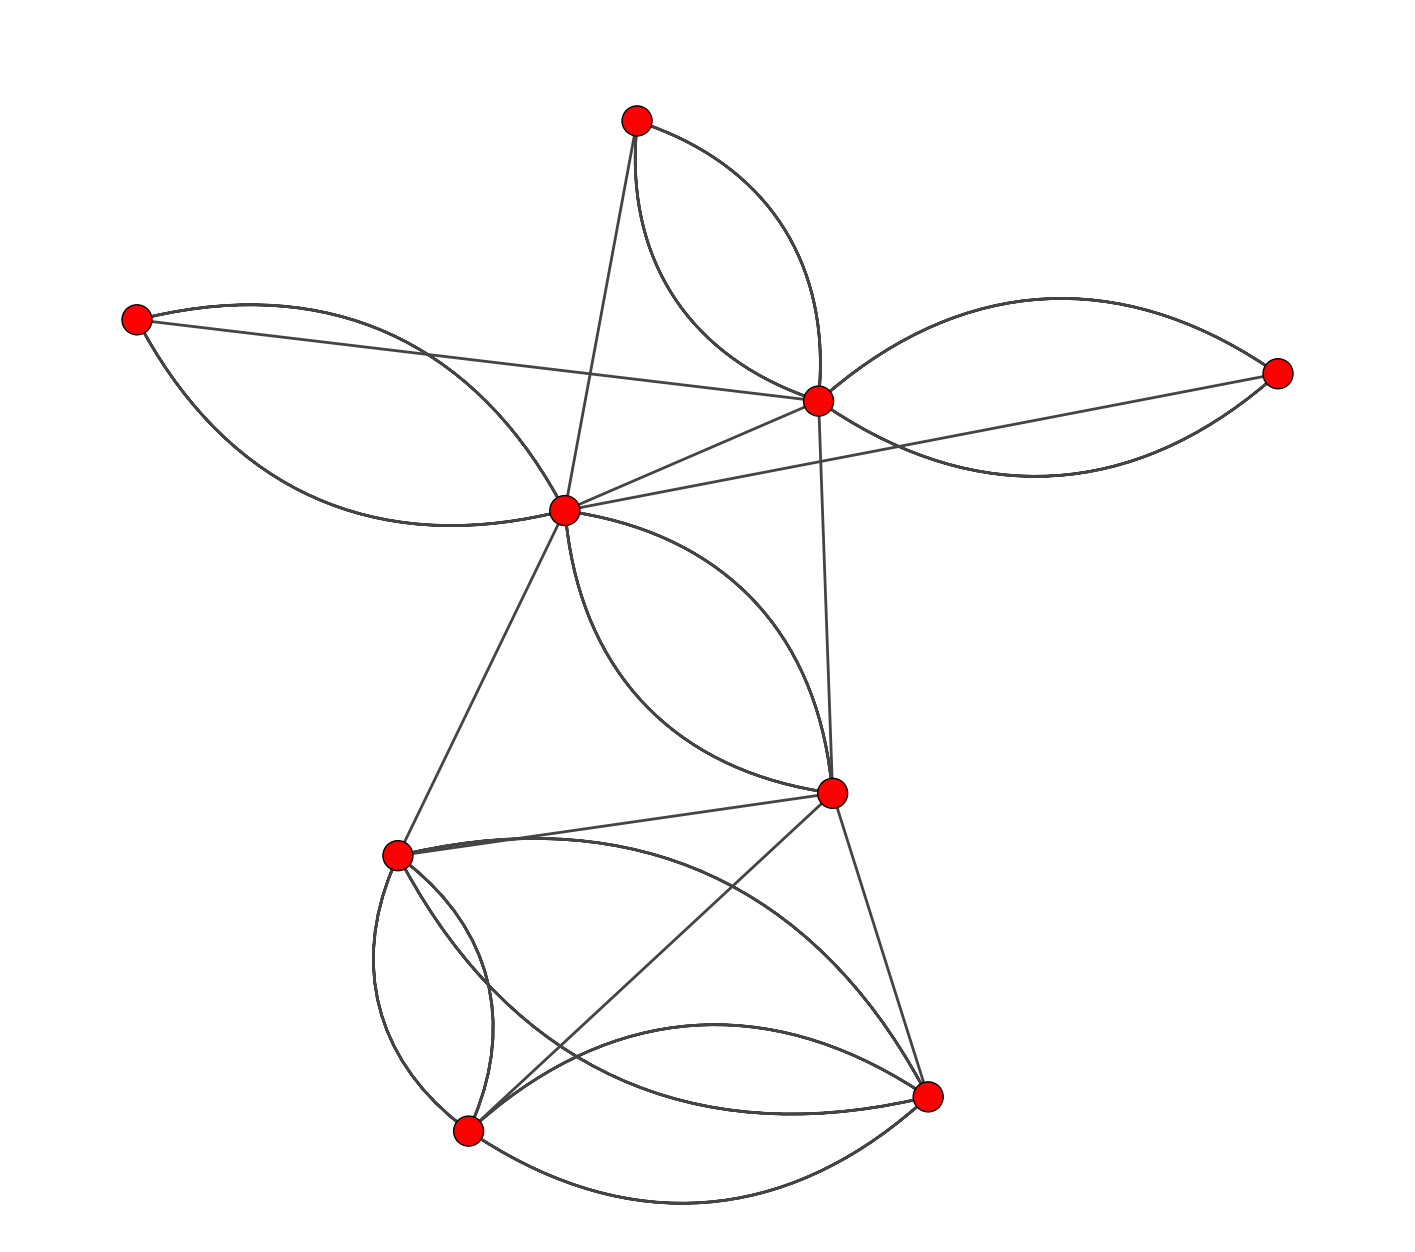

 Time it took to compute merge_graphs function:  0.32265
 Time it took to compute similarity_matrix function:  3e-05
Using optimal t value of 8
 Time it took to compute diffusion process:  0.00378
Fit process finished. We recommend calling optimize_by_creating_connections.


In [4]:
test = MASH(t = -1, knn = 2, distance_measures= ["default", "euclidean", "default"], verbose = 7)
test.fit([d1, d2, d3], np.array([[np.nan, 0, 0],
                                 [2, 2, np.nan]]))

### Actual data


In [4]:
dc0a = tma.test_manifold_algorithms("iris.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)
dc0b = tma.test_manifold_algorithms("seeds.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)

 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

MDS initialized with 7 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [5]:
md = MASH(t = -1, knn = 5, distance_measures= ["default", "euclidean", "default"], verbose = 7)

In [6]:
#Testing fit portions
md.domains = [dc0a.split_A, dc0b.split_B, dc0a.split_B]
md.domain_count = len(md.domains)
md.build_graphs()

 Time it took to execute the graph for domain 0:  0.2046
 Time it took to compute kernal 0:  0.00084
 Time it took to execute SGDM for domain 1:  0.00161
 Time it took to execute the graph for domain 1:  0.2152
 Time it took to execute the graph for domain 2:  0.18278
 Time it took to compute kernal 2:  0.00035


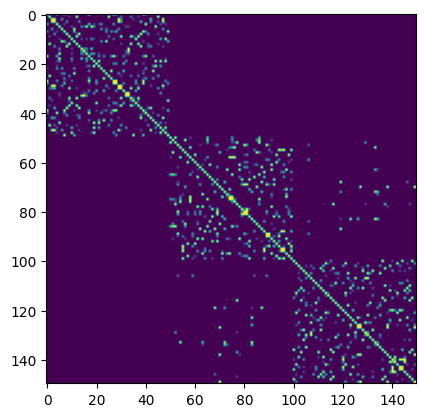

In [7]:
plt.imshow(md.kernals[0])

In [8]:
known_anchors = np.column_stack([dc0a.anchors[:, 0], dc0b.anchors[:150, 0], dc0a.anchors[:, 1]])
known_anchors[:4]

array([[ 28, 163,  28],
       [  6,  28,   6],
       [ 70,   6,  70],
       [ 62, 189,  62]])

In [9]:
#Ensure labels correspond to class
md.known_anchors = np.array([])
for anchors in known_anchors:
    if dc0a.labels[anchors[0]] == dc0b.labels[anchors[1]]:
        if len(md.known_anchors) < 1:
            md.known_anchors = anchors
        else:
            md.known_anchors = np.vstack([md.known_anchors, anchors])

md.known_anchors[-5:]

array([[127, 138, 127],
       [136, 134, 136],
       [119, 164, 119],
       [ 18,  14,  18],
       [ 95,  76,  95]])

In [10]:
dc0a.labels[[6, 57, 35]], dc0b.labels[[28,70,62]]

(array([1, 2, 1]), array([1, 2, 1]))

In [11]:
#Cache the lengths of the domains
md.len_domains = [len(domain) for domain in md.domains]
for length in md.len_domains:
    print(length)

150
199
150


In [12]:
md.known_anchors_adjusted = np.array(md.known_anchors)
for i, length in enumerate(md.len_domains):
    if i == len(md.domains) - 1:
        break
    else:
        md.known_anchors_adjusted += np.concatenate((np.repeat(0, i+1), np.repeat(length, len(md.domains)-(i+1))))
md.known_anchors_adjusted[:4], md.known_anchors[:4]

(array([[  6, 178, 355],
        [ 57, 220, 406],
        [ 35, 212, 384],
        [ 26, 207, 375]]),
 array([[ 6, 28,  6],
        [57, 70, 57],
        [35, 62, 35],
        [26, 57, 26]]))

In [13]:
anc = np.array(md.known_anchors, dtype = float)
anc[10][0] = np.nan
md.known_anchors = anc

In [14]:
~np.isnan(md.known_anchors[10][0]), type(md.known_anchors[10][0]), md.known_anchors[10][0], type(md.known_anchors[10][1]), md.known_anchors[10][1]

(False, numpy.float64, nan, numpy.float64, 67.0)

Time Data Below
 Time it took to execute the graph for domain 0:  0.85002
 Time it took to compute kernal 0:  0.00054
 Time it took to execute SGDM for domain 1:  0.00079
 Time it took to execute the graph for domain 1:  0.19477
 Time it took to execute the graph for domain 2:  0.13632
 Time it took to compute kernal 2:  0.00018
Length of weights to add: 36
Length of edges to add: 6
Length of edges to add: 6
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 7
Length of edges to add: 7
Length of weights to add: 34
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 7
Length of edges to add: 7
Length of weights to add: 36
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 8
Length of edges to add: 8
Length of edges to add: 5
Length of edges to add: 5
Length of weights to add: 48
Length of edges to add: 8
Length of edges to add: 8
Length of edges to add: 10
Length

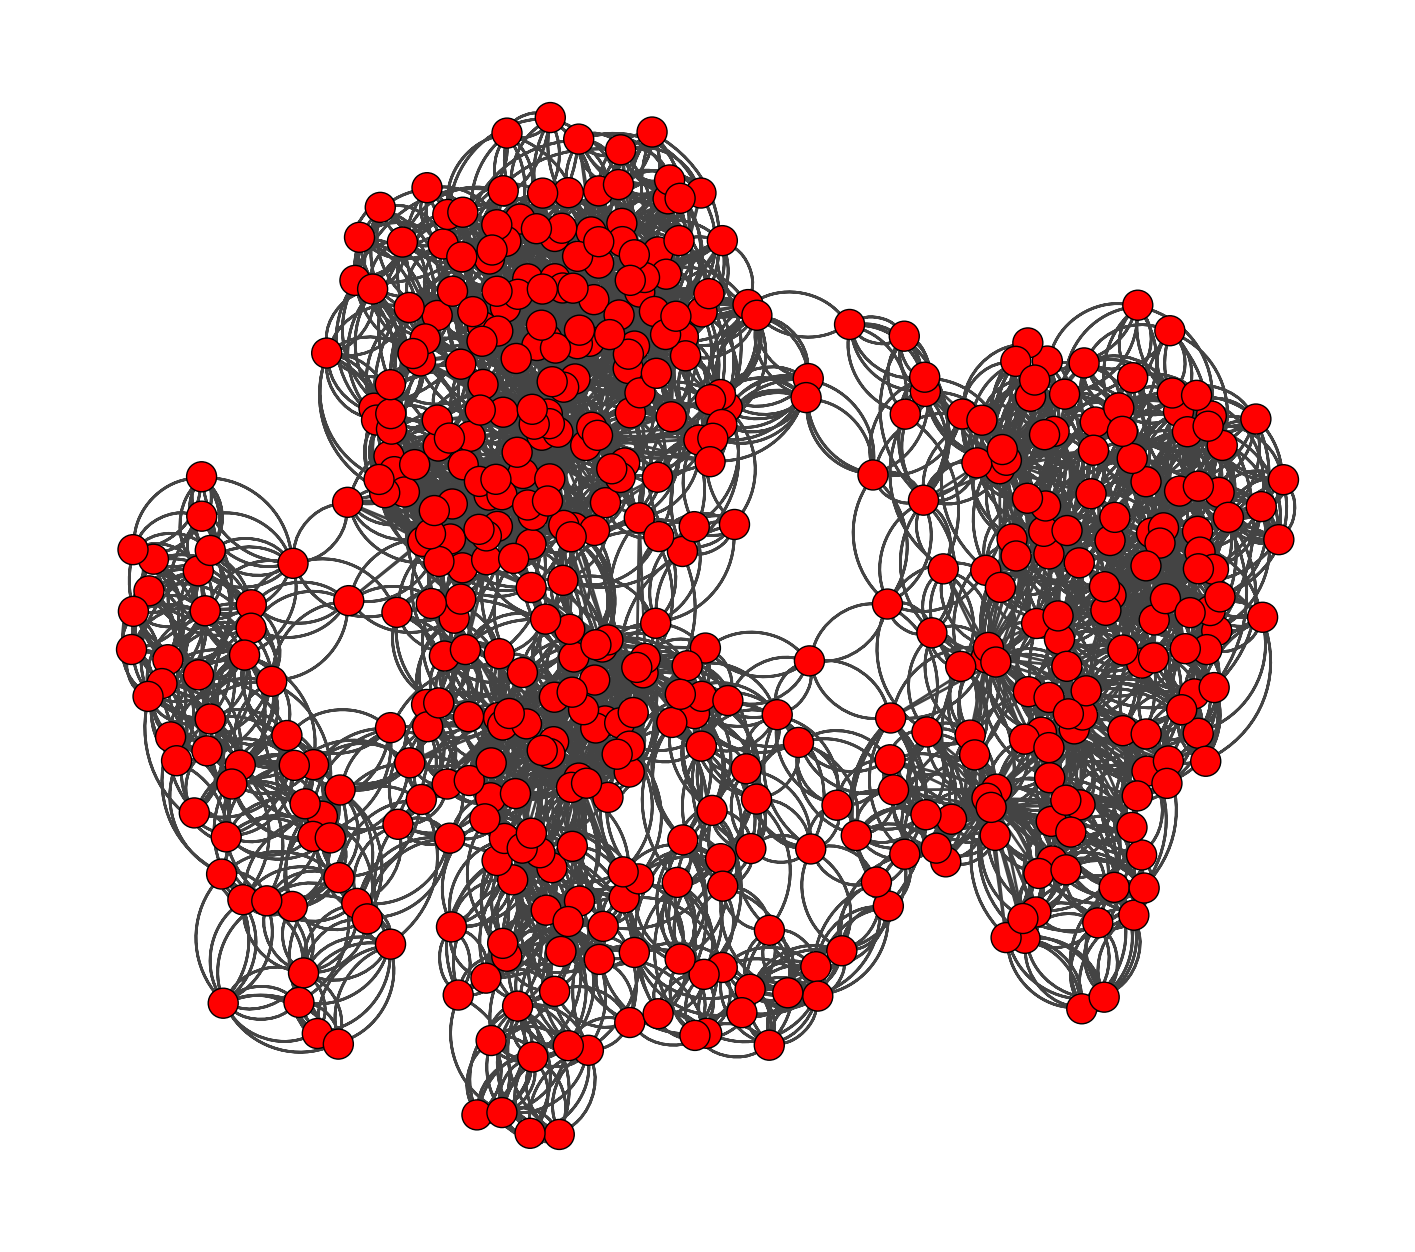

 Time it took to compute merge_graphs function:  18.77643
 Time it took to compute similarity_matrix function:  0.00386
Using optimal t value of 16
 Time it took to compute diffusion process:  4.24448
Fit process finished. We recommend calling optimize_by_creating_connections.


In [15]:
md.fit([dc0a.split_A, dc0b.split_B, dc0a.split_B], md.known_anchors[5:30])

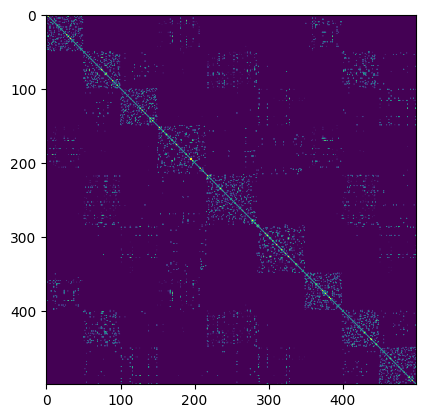

In [16]:
plt.imshow(md.graphAB)

(<matplotlib.image.AxesImage at 0x7fa8caa1ffa0>, 349, [150, 199, 150])

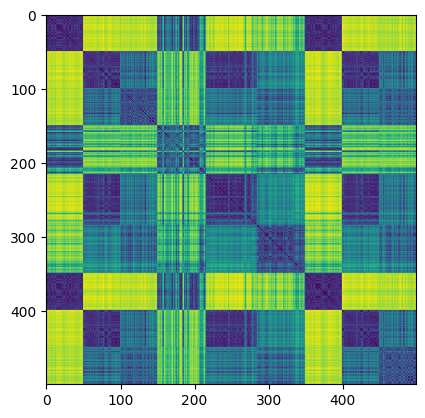

In [17]:
plt.imshow(md.int_diff_dist), sum(md.len_domains[:2]), md.len_domains

<Axes: >

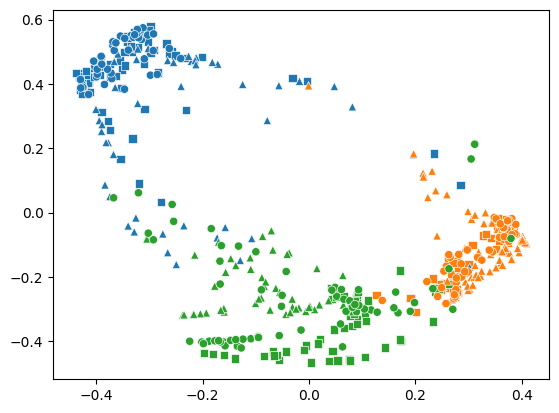

In [18]:
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS


#NOTE -> The coloring might be wrong on this graph
mds = MDS(metric=True, dissimilarity = 'precomputed', random_state = 42, n_components=2)
labels_tripled = np.concatenate([dc0a.labels, dc0b.labels, dc0a.labels])
emb1 = mds.fit_transform(md.int_diff_dist)
styles = ['Graph1' if i < len(emb1[:]) / 3 else 'Graph2' if i < len(emb1[:]) * (2 / 3) else "Graph3" for i in range(len(emb1[:]))]

sns.scatterplot(legend = False, x = emb1[:, 0], y = emb1[:, 1], hue = pd.Categorical(labels_tripled), style = styles, markers = {"Graph1": 's', "Graph2": "^", "Graph3": "o"})

(150, 2)
(199, 2)
(150, 2)


/tmp/ipykernel_3753863/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


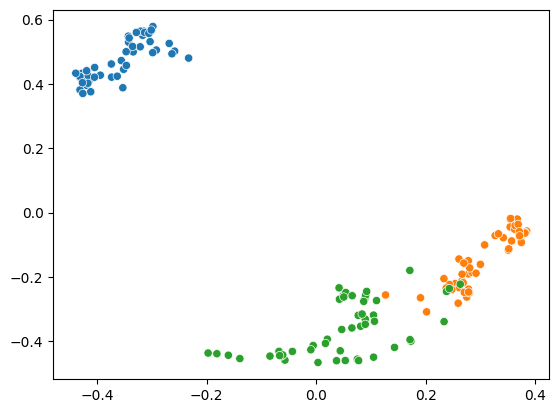

/tmp/ipykernel_3753863/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


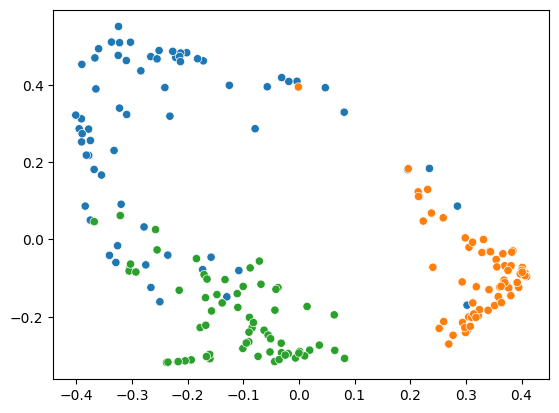

/tmp/ipykernel_3753863/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


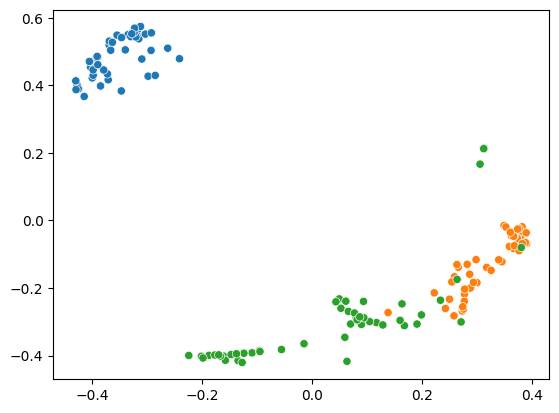

In [19]:
#Sort out the embedding by domains
embeddings = [emb1[:md.len_domains[0], :]]
print(embeddings[0].shape)

for i in range(1, md.domain_count):
    embeddings.append(emb1[sum(md.len_domains[:i]):sum(md.len_domains[:i+1]),:])
    print(embeddings[i].shape)


for emb, labels in zip(embeddings, [dc0a.labels, dc0b.labels, dc0a.labels]):
    sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))
    plt.show()

Scores from domain 1 to 2: 
    Cross Embedding: 0.928107202680067


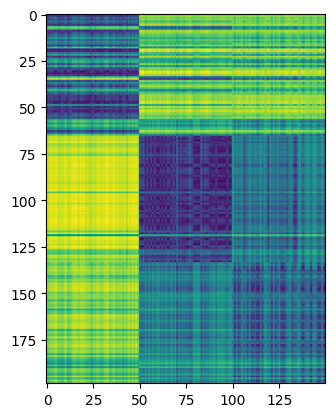

    Can't compute FOSCTTM with different domain shapes. Domain 1: (150, 4). Domain 2: (199, 7)
Scores from domain 1 to 3: 
    Cross Embedding: 0.9333333333333333


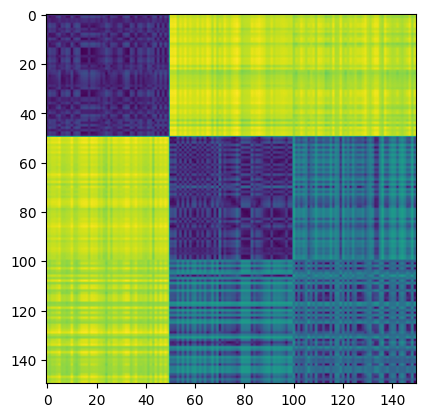

    FOSCTTM: 0.06399999999999999
Scores from domain 2 to 3: 
    Cross Embedding: 0.8963651591289783


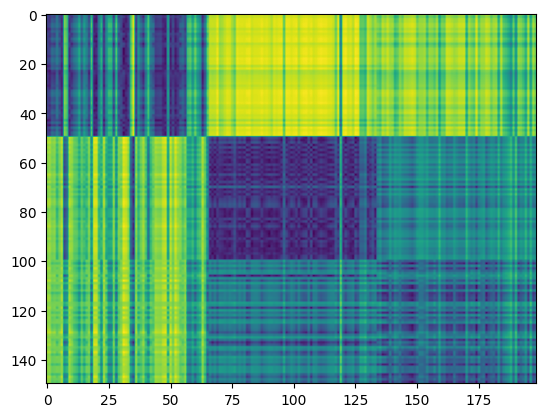

    Can't compute FOSCTTM with different domain shapes. Domain 2: (199, 7). Domain 3: (150, 4)


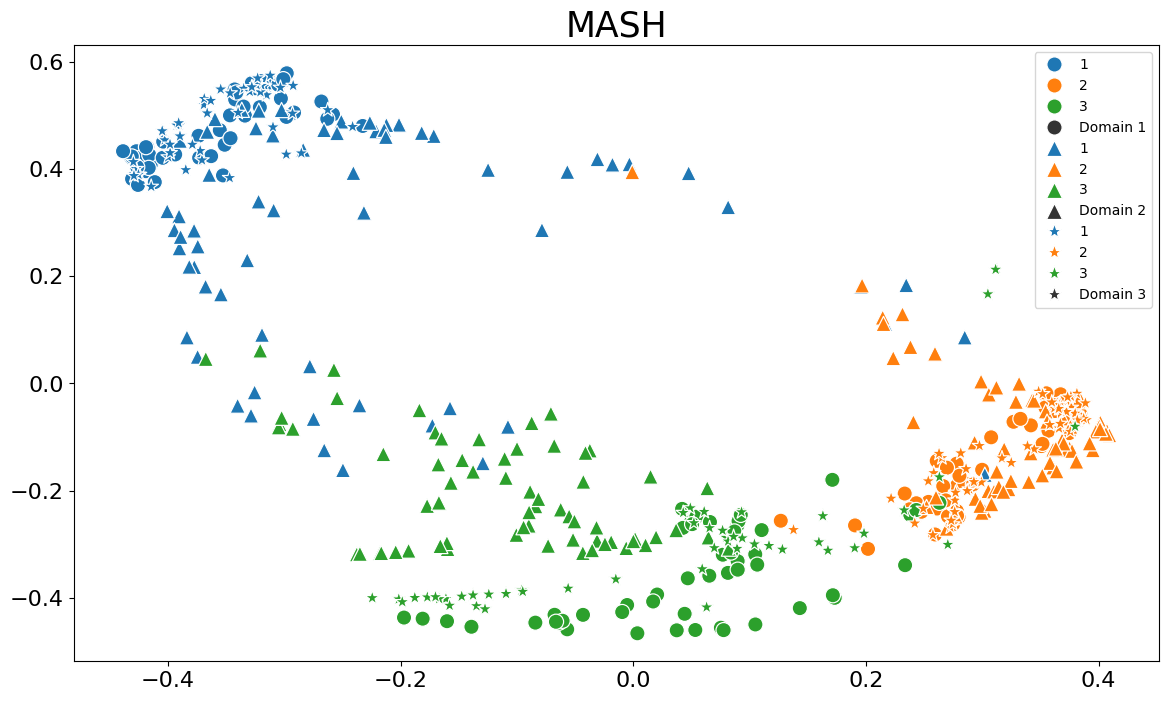

In [20]:
md.plot_emb([dc0a.labels, dc0b.labels, dc0a.labels], n_comp = 2)

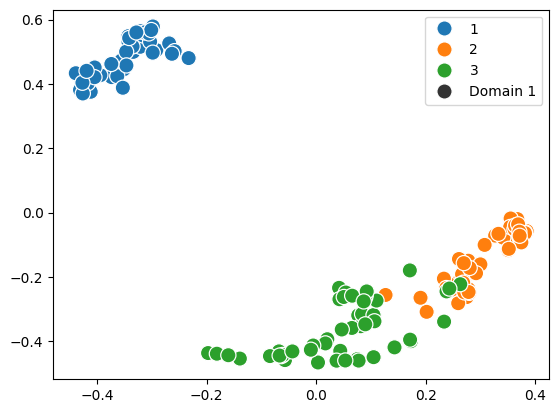

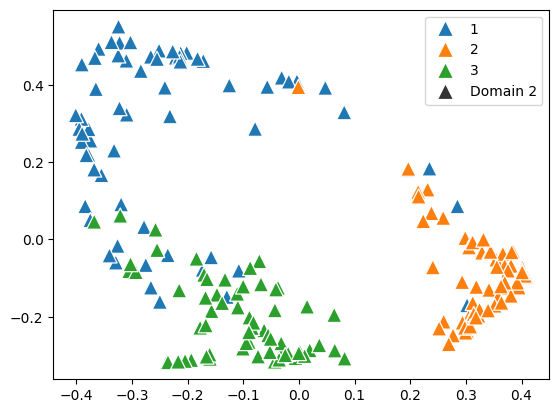

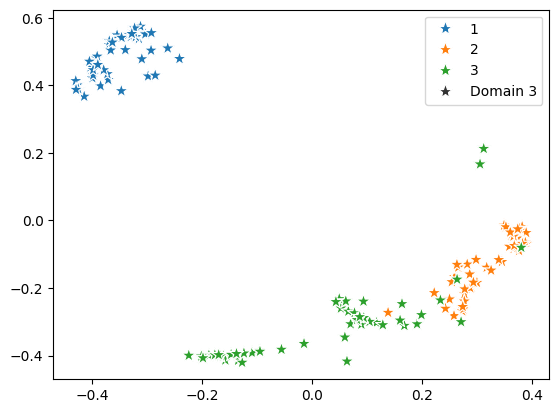

In [21]:
md.plot_all_embeddings([dc0a.labels, dc0b.labels, dc0a.labels])

## Seperating Features to be seperate domains

In [22]:
#Create tma
dc1 = tma.test_manifold_algorithms("iris.csv", split = "distort")

In [23]:
#Set up data
domains1 = np.reshape([dc1.split_A[:, 0], dc1.split_A[:, 1], dc1.split_A[:, 2], dc1.split_A[:, 3]], newshape = (4,150, 1)) # Testing seperating features to be seperate domains
labels1 = [dc1.labels, dc1.labels, dc1.labels, dc1.labels]
known_anchors1 = np.hstack([dc1.anchors, dc1.anchors])

In [24]:
md2 = MASH(knn = 5, verbose = 3)
md2.fit(domains1, known_anchors1[:30])

Using optimal t value of 14
Fit process finished. We recommend calling optimize_by_creating_connections.


Scores from domain 1 to 2: 
    Cross Embedding: 0.58
    FOSCTTM: 0.3836888888888889
Scores from domain 1 to 3: 
    Cross Embedding: 0.6633333333333333
    FOSCTTM: 0.3416888888888889
Scores from domain 1 to 4: 
    Cross Embedding: 0.71
    FOSCTTM: 0.3252
Scores from domain 2 to 3: 
    Cross Embedding: 0.6
    FOSCTTM: 0.3676
Scores from domain 2 to 4: 
    Cross Embedding: 0.5633333333333332
    FOSCTTM: 0.3589333333333334
Scores from domain 3 to 4: 
    Cross Embedding: 0.7966666666666666
    FOSCTTM: 0.25657777777777774


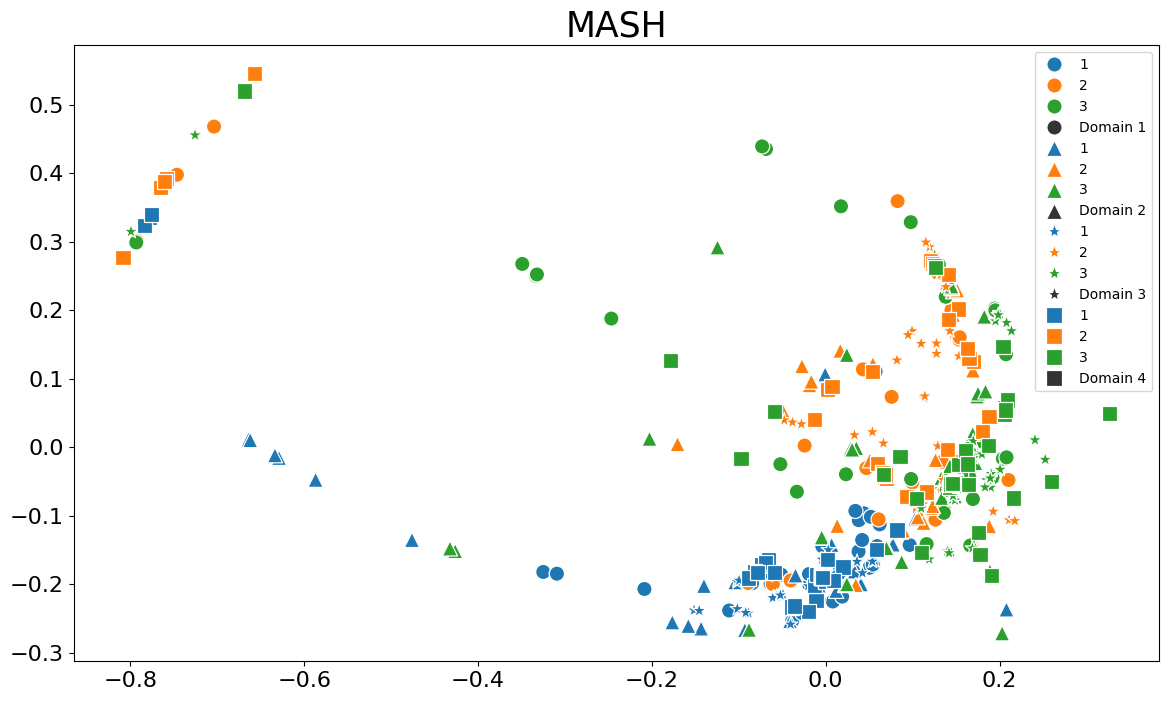

In [25]:
md2.plot_emb(labels1)

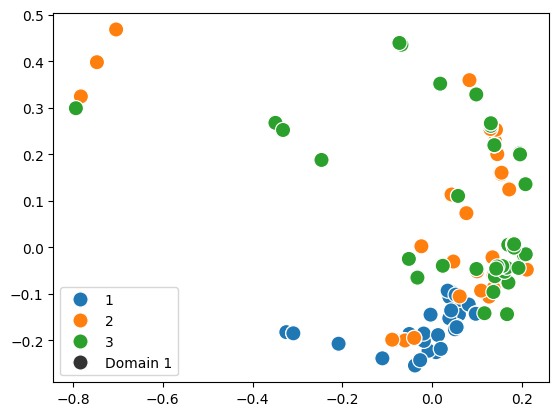

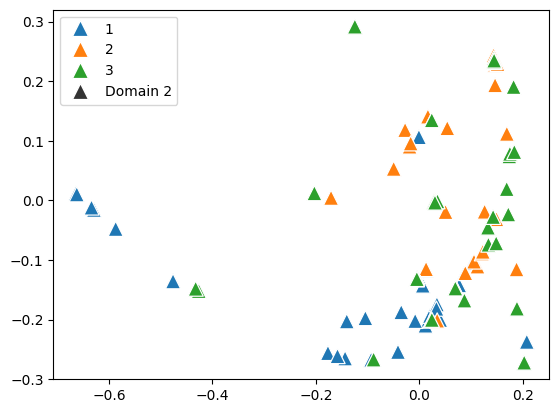

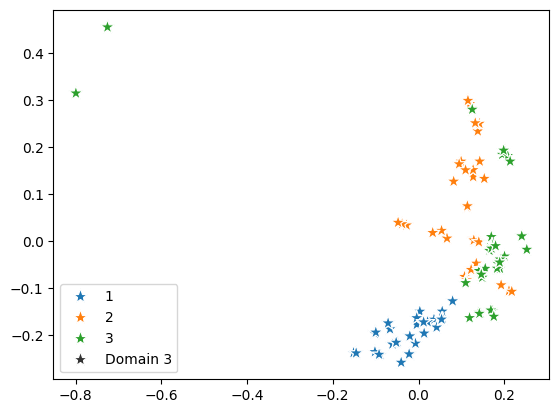

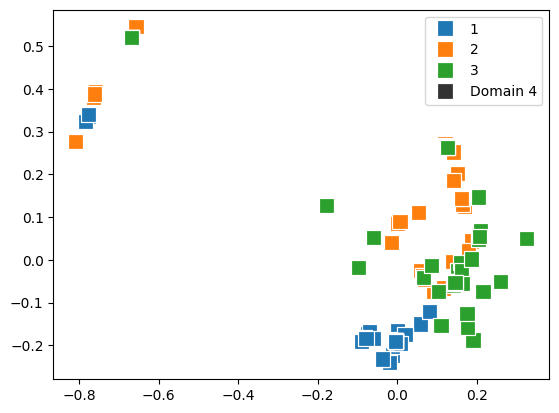

In [26]:
md2.plot_all_embeddings(labels1)

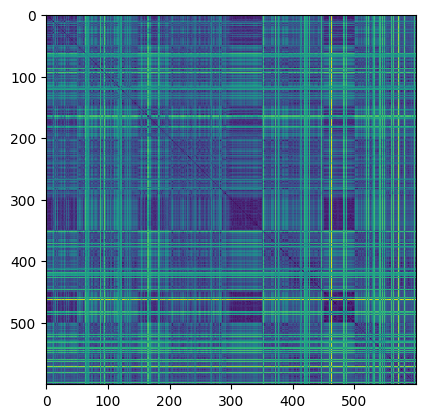

In [27]:
plt.imshow(md2.int_diff_dist)